In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [2]:
import numpy as np
import random
import pandas as pd
# from pylab import mpl, plt
# plt.style.use('seaborn')
# mpl.rcParams['font.family'] = 'serif'
# %matplotlib inline


# from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))


In [31]:
import matplotlib.pyplot as plt

## 2. Load data

In [7]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("../input/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

In [8]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True)

FileNotFoundError: [Errno 2] No such file or directory: '../input/Data/Stocks/goog.us.txt'

In [4]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


In [13]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("../input/Data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
# plt.ylabel("stock_price")
# plt.title("IBM Stock")
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../input/Data/Stocks/ibm.us.txt'

In [23]:
from data.main import download_data

data = download_data("0700.hk", history = "10y")

In [24]:
data.shape

(2465, 5)

In [27]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [12]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

NameError: name 'df_ibm' is not defined

In [20]:
data=data.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data.values.reshape(-1,5))

/var/folders/q0/6612k10n5b1gb0np_s2bjjmr0000gn/T/ipykernel_27200/3302040552.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data=data.fillna(method='ffill')


In [21]:
data.shape

(2465, 5)

In [7]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm

In [25]:
data[["Close"]]

,Close
Date,
2013-11-11 00:00:00+08:00,-0.989393
2013-11-12 00:00:00+08:00,-0.990648
2013-11-13 00:00:00+08:00,-1.000000
2013-11-14 00:00:00+08:00,-0.989622
2013-11-15 00:00:00+08:00,-0.984603
...,...
2023-11-02 00:00:00+08:00,-0.374319
2023-11-03 00:00:00+08:00,-0.333107
2023-11-06 00:00:00+08:00,-0.303670


In [56]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 120 # choose sequence length
x_train, y_train, x_test, y_test = load_data(data[["Close"]], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1875, 119, 1)
y_train.shape =  (1875, 1)
x_test.shape =  (469, 119, 1)
y_test.shape =  (469, 1)


In [57]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [58]:
y_train.size(),x_train.size()

(torch.Size([1875, 1]), torch.Size([1875, 119, 1]))

## 3. Build the structure of model

In [4]:
# Build model
#####################
input_dim = 1
hidden_dim = 64
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        print(out.size())

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

In [8]:
model(torch.rand((2,119,1)))

torch.Size([2, 119, 64])


tensor([[0.0180],
        [0.0182]], grad_fn=<AddmmBackward0>)

In [60]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.02506956458091736
Epoch  20 MSE:  0.006014721468091011
Epoch  30 MSE:  0.003148580901324749
Epoch  40 MSE:  0.002262794179841876
Epoch  50 MSE:  0.001461689011193812
Epoch  60 MSE:  0.0010963991517201066
Epoch  70 MSE:  0.0010111398296430707
Epoch  80 MSE:  0.0009567916276864707
Epoch  90 MSE:  0.0009317242656834424


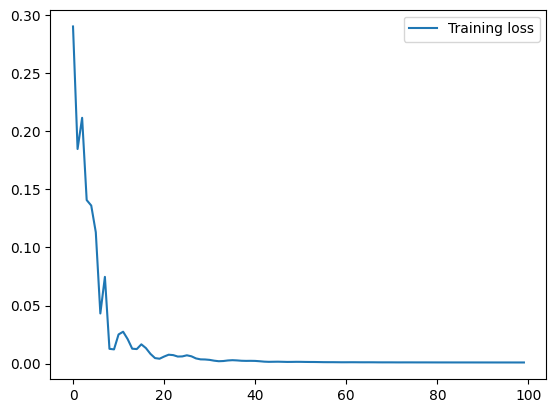

In [61]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [62]:
np.shape(y_train_pred)

torch.Size([1875, 1])

In [63]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.26 RMSE
Test Score: 12.38 RMSE


In [64]:
data = data[["Close"]]

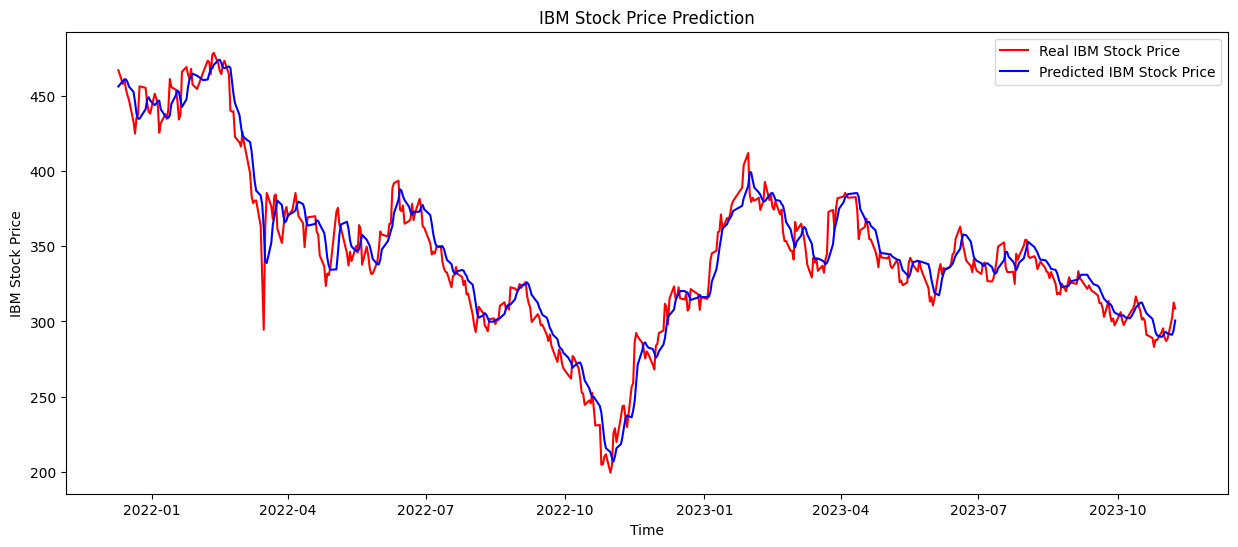

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data[len(data)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(data[len(data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()